In [2]:
!pip install torch
import torch

import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

zsh:1: command not found: pip


In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [5]:
class Neuron:
  def __init__(self, nin):
    self.w =[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs
  def parameters(self):
    return [p for neurons in self.neurons for p in neurons.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts    # add the input dimension as first layer and after that each layer will have previous layer n neurons output as n dimentional input , the last layer will have only one neuron so that we can have one prediction it can also have mutiple outputs but here it iwll be one.
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x= layer(x)
    return x;
  def parameters(self):
    return [p for layers in self.layers for p in layers.parameters()]

## Cat vs Not-Cat Image Classification

We'll train on tiny 16×16 grayscale images (only 256 pixels!)
- Input: 256 pixel values
- Output: 1 (cat) or 0 (not cat)
- Network: Small MLP to keep it fast

In [6]:
from PIL import Image
import os

def load_and_resize_images(folder_path, max_images=50, img_size=16):
    """
    Load cat images and resize to tiny grayscale images
    Returns list of normalized pixel values [-1, 1]
    
    OPTIMIZED: Smaller images (8x8) and fewer examples for speed
    """
    images = []
    
    # Get only .jpg files (not .cat annotation files)
    jpg_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    jpg_files = jpg_files[:max_images]  # Take only first N images
    
    print(f"Loading {len(jpg_files)} images...")
    
    for i, img_file in enumerate(jpg_files):
        img_path = os.path.join(folder_path, img_file)
        
        # Open image
        img = Image.open(img_path)
        
        # Convert to grayscale (1 channel instead of 3 RGB)
        img = img.convert('L')
        
        # Resize to TINY size (8x8 = only 64 pixels for speed!)
        img = img.resize((img_size, img_size))
        
        # Convert to list of pixel values (0-255)
        pixels = list(img.getdata())
        
        # Normalize to [-1, 1] range for better training
        pixels = [(p / 127.5) - 1.0 for p in pixels]
        
        images.append(pixels)
        
        if (i+1) % 20 == 0:
            print(f"  Loaded {i+1}/{len(jpg_files)}...")
    
    print(f"✓ Loaded {len(images)} images")
    print(f"  Each image: {img_size}×{img_size} = {len(images[0])} pixels")
    print(f"  Pixel range: [{min(images[0]):.2f}, {max(images[0]):.2f}]")
    
    return images

# OPTIMIZED: Only 50 images, 8×8 pixels (64 inputs instead of 256!)
cat_folder = '/Users/rajneesh/Desktop/projects/neural-nets/dataset/cat/CAT_00'
cat_images = load_and_resize_images(cat_folder, max_images=25, img_size=64)

Loading 25 images...
  Loaded 20/25...
✓ Loaded 25 images
  Each image: 64×64 = 4096 pixels
  Pixel range: [-0.91, 1.00]


In [7]:
# For binary classification, we need "not cat" images too
# We'll create simple random noise images as negative examples

def create_non_cat_images(num_images, img_size=16):
    """Create synthetic non-cat images (random pixel patterns)"""
    non_cats = []
    
    for _ in range(num_images):
        # Random pixels in range [-1, 1]
        pixels = [random.uniform(-1, 1) for _ in range(img_size * img_size)]
        non_cats.append(pixels)
    
    return non_cats

# OPTIMIZED: Only 50 non-cat images to match
non_cat_images = create_non_cat_images(25, img_size=64)
print(f"✓ Created {len(non_cat_images)} non-cat images (random noise)")

# Combine and prepare training data
xs = cat_images + non_cat_images
ys = [1.0] * len(cat_images) + [-1.0] * len(non_cat_images)  # 1=cat, -1=not cat

# Shuffle the data
combined = list(zip(xs, ys))
random.shuffle(combined)
xs, ys = zip(*combined)
xs, ys = list(xs), list(ys)

print(f"\n📊 Training Dataset:")
print(f"  Total examples: {len(xs)}")
num_cats = sum(1 for y in ys if y == 1.0)
num_not_cats = sum(1 for y in ys if y == -1.0)
print(f"  Cats: {num_cats}, Not-cats: {num_not_cats}")

✓ Created 25 non-cat images (random noise)

📊 Training Dataset:
  Total examples: 50
  Cats: 25, Not-cats: 25


In [8]:

n = MLP(4096, [32,16,1])

total_params = len(n.parameters())
print(f"🧠 Neural Network Created!")
print(f"  Total parameters: {total_params}")


🧠 Neural Network Created!
  Total parameters: 131649


In [9]:
import time
from typing import Any


start_time = time.time()

# Cache parameters and length (avoid repeated calls)
params = n.parameters()
num_examples = len(xs)

for epoch in range(20):
    epoch_start = time.time()

    for p in params:
        p.grad = 0.0
    
    # forward pass
    yprid = [n(x) for x in xs]
    loss = sum(((yout[0]-ygt)*(yout[0]-ygt)) for ygt, yout in zip(ys, yprid))    

    
    # Backward pass (compute gradients)
    loss.backward()
    
    # update 0.06 [ 5 epoc ] to 0.01[ 10 epoc ] to 0.015[ 20 epoc ] to 0.013[ 5 epoc ]
    learning_rate = 0.02
    for p in params:
        p.data += -learning_rate * p.grad
    
    epoch_time = time.time() - epoch_start
    
    
    print(f"Epoch {epoch+1:2d}/5 | Loss: {loss.data/len(xs)} | Time: {epoch_time:.1f}s")
    
    # Early stopping
    if loss.data/len(xs) < 0.05:
        print(f"\n✅ Converged at epoch {epoch+1}!")
        break

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time:.1f} seconds!")
print(f"Final loss: {loss}")
print(f"💡 Much faster with optimizations!")

RecursionError: maximum recursion depth exceeded while calling a Python object

In [9]:
# Test the trained model on some examples

print("🧪 Testing predictions:\n")

# Test on a few training examples
test_indices = [1,3,5,24,7,14,26]  # Sample different examples

for idx in test_indices:
    x_test = xs[idx]
    y_true = ys[idx]
    
    # Get prediction
    y_pred = n(x_test)[0]
    
    pred_value = y_pred.data
    pred_label = "🐱 Cat" if pred_value > 0 else "❌ Not Cat"
    true_label = "🐱 Cat" if y_true == 1.0 else "❌ Not Cat"
    
    correct = "✓" if (pred_value > 0) == (y_true == 1.0) else "✗"
    
    print(f"Example {idx}: {true_label} | Predicted: {pred_label} ({pred_value:.3f}) {correct}")

🧪 Testing predictions:

Example 1: ❌ Not Cat | Predicted: ❌ Not Cat (-0.921) ✓
Example 3: 🐱 Cat | Predicted: 🐱 Cat (0.948) ✓
Example 5: ❌ Not Cat | Predicted: ❌ Not Cat (-0.990) ✓
Example 24: 🐱 Cat | Predicted: 🐱 Cat (0.971) ✓
Example 7: 🐱 Cat | Predicted: 🐱 Cat (0.903) ✓
Example 14: 🐱 Cat | Predicted: 🐱 Cat (1.000) ✓
Example 26: ❌ Not Cat | Predicted: ❌ Not Cat (-0.951) ✓


In [10]:
# Predict on NEW cat images (not used in training!)

def predict_image(image_path, network, img_size=16):
    """Load an image and predict if it's a cat"""
    
    # Load and preprocess (same as training)
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((img_size, img_size))
    pixels = list(img.getdata())
    pixels = [(p / 127.5) - 1.0 for p in pixels]
    
    # Get prediction
    prediction = network(pixels)[0]
    pred_value = prediction.data
    
    # Interpret (network outputs +1 for cat, -1 for not cat)
    if pred_value > 0.5:
        result = "🐱 Definitely a CAT!"
    elif pred_value > 0:
        result = "🐱 Probably a cat"
    elif pred_value > -0.5:
        result = "🤔 Maybe a cat?"
    else:
        result = "❌ Not a cat"
    
    return pred_value, result

# Test on new images (images 51-55 that weren't used in training)
print("🔮 Predicting on NEW cat images:\n")

cat_folder = '/Users/rajneesh/Desktop/projects/neural-nets/dataset/cat/CAT_01'
test_files = sorted([f for f in os.listdir(cat_folder) if f.endswith('.jpg')])[50:55]

for img_file in test_files:
    img_path = os.path.join(cat_folder, img_file)
    pred_value, result = predict_image(img_path, n, img_size=16)
    print(f"{img_file}: {result} (score: {pred_value:.3f})")



dog_folder = '/Users/rajneesh/Desktop/projects/neural-nets/dataset/dog'
test_files = sorted([f for f in os.listdir(dog_folder) if f.endswith('.jpg')])

for img_file in test_files:
    img_path = os.path.join(dog_folder, img_file)
    pred_value, result = predict_image(img_path, n, img_size=16)
    print(f"{img_file}: {result} (score: {pred_value:.3f})")

🔮 Predicting on NEW cat images:

00000106_002.jpg: 🐱 Definitely a CAT! (score: 0.953)
00000106_003.jpg: 🐱 Definitely a CAT! (score: 0.999)
00000106_006.jpg: 🐱 Probably a cat (score: 0.121)
00000106_009.jpg: 🐱 Definitely a CAT! (score: 0.932)
00000106_014.jpg: ❌ Not a cat (score: -0.973)
dog.jpg: ❌ Not a cat (score: -0.918)
dog02.jpg: 🤔 Maybe a cat? (score: -0.287)
dog_01.jpg: 🐱 Definitely a CAT! (score: 0.908)
eli001.jpg: 🐱 Definitely a CAT! (score: 0.990)
goat.jpg: 🤔 Maybe a cat? (score: -0.284)


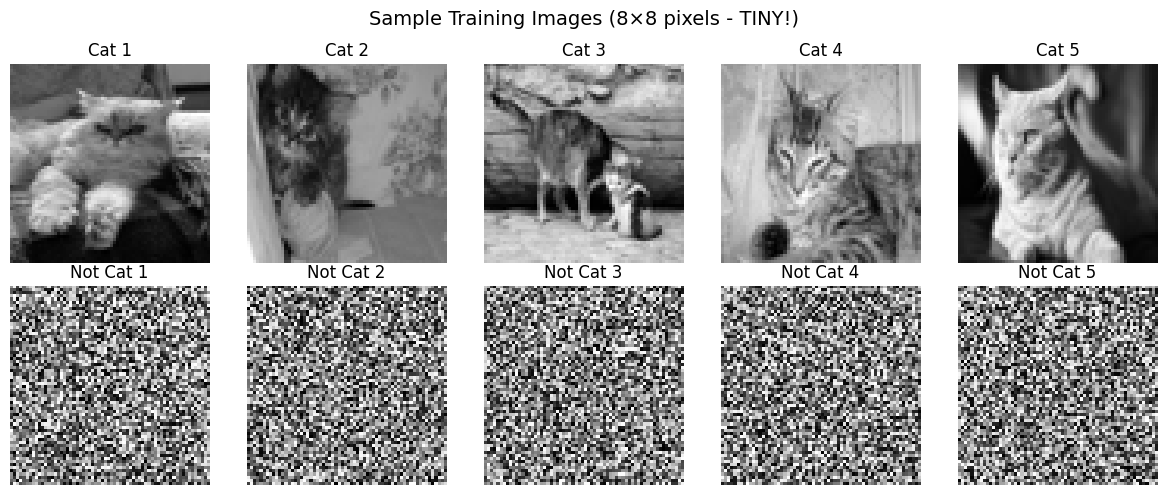

👆 These TINY 8×8 images are what your neural network learned from!
Each image is only 64 pixels - that's why training is so much faster!


In [10]:
# Optional: Visualize some resized images to see what the network "sees"

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Training Images (8×8 pixels - TINY!)', fontsize=14)

# Show 5 cats and 5 non-cats
for i in range(5):
    # Cat image
    cat_pixels = cat_images[i]
    cat_img = np.array(cat_pixels).reshape(64,64)
    axes[0, i].imshow(cat_img, cmap='gray', interpolation='nearest')
    axes[0, i].set_title(f'Cat {i+1}')
    axes[0, i].axis('off')
    
    # Non-cat image (random noise)
    noncat_pixels = non_cat_images[i]
    noncat_img = np.array(noncat_pixels).reshape(64,64)
    axes[1, i].imshow(noncat_img, cmap='gray', interpolation='nearest')
    axes[1, i].set_title(f'Not Cat {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("👆 These TINY 8×8 images are what your neural network learned from!")
print("Each image is only 64 pixels - that's why training is so much faster!")

In [ ]:
# download the cats 
# curl -L -o /Users/rajneesh/Desktop/projects/neural-nets/dataset/cat-dataset.zip\
#   https://www.kaggle.com/api/v1/datasets/download/crawford/cat-dataset